# Solving PDE's with feed forward neural networks using Autograd

#### Implementation feed forward procedure, the learning scheme, and setting up the weights and biases:

In [22]:
import autograd.numpy as np
from autograd import grad, elementwise_grad, jacobian
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys


def feedforward(X, P, act_func):
    """
    Feed forward precedure for a network
    define by the weights and biases P, 
    and the activation functions act_func.
    """
    
    dim = len(P)
    z = np.array(X)
    
    for i in range(dim):
        z = np.concatenate((z, np.ones((z.shape[0], 1))), axis=1)
        z = act_func[i](z @ P[i])

    return z


def gradient_decent(X, P, act_func, cost, mu, N):
    gradient = elementwise_grad(cost, 1)
    
    for i in range(N):
        grad = gradient(X, P, act_func)    
        
        for j in range(len(P)):
            P[j] -= mu*grad[j]
            
        if i%(N/100) == 0:
            loss = cost(X, P, act_func)
            print(f"loss={loss:.3}, {i/(N/100)}/100", end = "\r")
            

def generate_P(dim):
    """
    Setting up the weights and biases to 
    normally distributes values. The dimmensions 
    are given by dim.
    """
    n = len(dim) - 1
    P = n * [None]
    for i in range(n):
        P[i] = np.random.normal(0, 1, (dim[i] + 1, dim[i + 1]))

    return P


def learning_rate(start_mu, stop_mu, N_cap, N):
    """
    Generates an array of learning rates, starting 
    at start_mu and capping at stop_mu after N_cap 
    number of steps, for a total of N steps
    """
    mu1 = np.linspace(start_mu, stop_mu, N_cap)
    mu2 = max_mu*np.ones(N - N_cap)
    mu = np.concatenate((mu1, mu2))
    return mu


def ray_quo(A, x):
    """
    Calculates a list of Rayleigh Quotients    
    from the matrix A and a list of the vectors x
    """
    x = x/np.sqrt(np.einsum("ij,ij->i", x, x)[:,np.newaxis])
    eig = np.einsum("ij,ij->i", x@A, x)
    return eig

## 1D Heat Equation

Setting up the trial function, cost function and gradient:

In [23]:
def initial_condition(x):
    return np.sin(np.pi*x)


def g_trial(x, t, P, act_func):
    X = [*zip(x,t)]
    return (1 - t)*initial_condition(x) + t*(1 - x)*x*feedforward(X, P, act_func)[:,0]


g_trial_x = elementwise_grad(g_trial, 0)
g_trial_xx = elementwise_grad(g_trial_x, 0)
g_trial_t = elementwise_grad(g_trial, 1)


def cost(X, P, act_func):
    x, t = X[:, 0], X[:, 1]
    LHS = g_trial_xx(x, t, P, act_func)
    RHS = g_trial_t(x, t, P, act_func)
    
    return np.mean((LHS - RHS)**2)

def analytical(x,t):
    return np.sin(np.pi*x)*np.exp(-np.pi**2*t)

Setting up data and the network:

In [ ]:
#temporal and spacial grid
N_x = 10
N_t = 10

x = np.linspace(0, 1, N_x)
t = np.linspace(0, 1, N_t)

#using meshgrid and ravel to make a set of points in space and time
X = np.meshgrid(x,t)
X = zip(X[0].ravel(), X[1].ravel())
X = np.array([*X])

#setting up dimmensions of network and choosing activation functions
dim = (2, 100, 50, 1)
#P = generate_P(dim)
act_func = [np.tanh, np.tanh, lambda x: x]  

N = 3000
mu = 1e-3

gradient_decent(X, P, act_func, cost, mu, N)

Function for plotting the solutions:

In [52]:
def plot_function(x_grid, t_grid, u):

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(x_grid, t_grid, u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    ax.view_init(20, 10)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    plt.show()

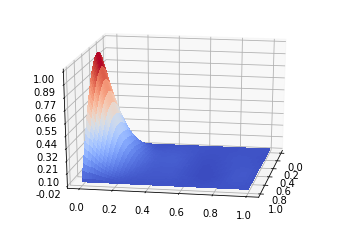

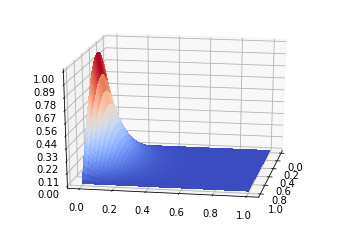

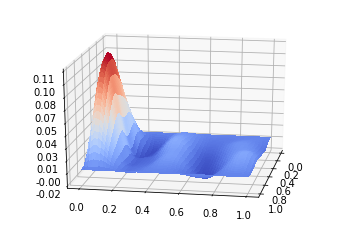

In [53]:
N = 100
x = np.linspace(0, 1, N)
t = np.linspace(0, 1, N)

x_grid, t_grid = np.meshgrid(x, t)
X = np.array([*zip(x_grid.ravel(), t_grid.ravel())])

u_nn = g_trial(X[:,0], X[:,1], P, act_func)
u_nn = u_nn.reshape(N, N)

u_anal = analytical(X[:,0], X[:,1])
u_anal = u_anal.reshape(N, N)

plot_function(x_grid, t_grid, u_nn)
plot_function(x_grid, t_grid, u_anal)
plot_function(x_grid, t_grid, u_nn - u_anal)

In [30]:
np.random.seed(42)

A = np.random.normal(0, 1, (3, 3))
A = (A.T + A)/2
x0 = np.array([1, 0, 0,])#np.random.normal(0, 1, 3)

print(np.linalg.eig(A))

def g_trial(t, P, act_func):
    #return np.exp(-t)*x0 +  (1 - np.exp(-t))*feedforward(t, P, act_func)
    return np.exp(-t)*x0 +  (1-np.exp(-t))*feedforward(t, P, act_func)


g_trial_t = jacobian(g_trial)


def f(A, x):
    return A@x - (x.T@x)*x#(x.T@x)*A@x - (x.T@A@x)*x
  

def cost(t, P, act_func):
    x = g_trial(t, P, act_func)
    
    LHS = g_trial_t(t, P, act_func)
    LHS = np.array([LHS[i,:,i].flatten() for i in range(len(t))])
    #print(x)
    RHS = np.array([f(A,i).flatten() for i in x])
    
    #print(RHS[:,:,0])
    #print(LHS)
    
    return np.mean((LHS - RHS)**2)
    

grad = elementwise_grad(cost,1)

(array([ 1.52741682, -1.23154257, -0.50278786]), array([[-0.78442334, -0.58538151,  0.20495978],
       [-0.38225031,  0.19604777, -0.90302268],
       [-0.48843088,  0.78669801,  0.37754672]]))


<IPython.core.display.Javascript object>


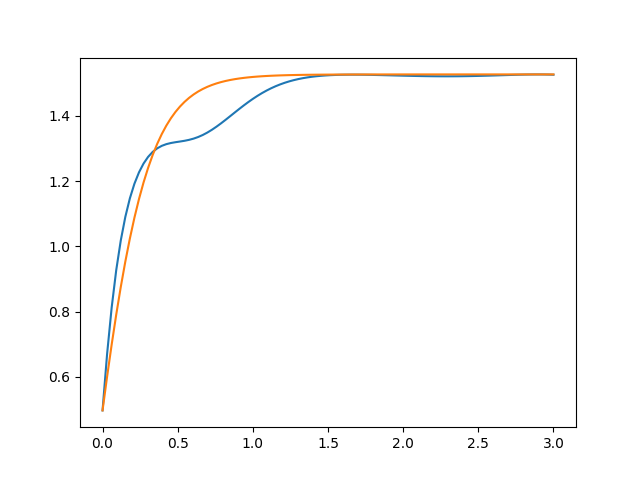

0.0
0.1235990347297147
-------------
1.0
0.10417178130865547
-------------
2.0
0.0890554408936954
-------------
3.0
0.07721666139951237
-------------


KeyboardInterrupt: 

In [45]:
np.random.seed(42)
%matplotlib notebook

#P = generate_P((1, 50, 3))
act_func = [np.tanh, lambda x: x]

n_train = 20
n_plot = 100

T = 3
t_train = np.expand_dims(np.linspace(0, T, n_train), axis = -1)
t_plot = np.linspace(0, T, n_plot)

dt = T/n_plot
x = [np.array([1, 0, 0])]
for i in range(n_plot-1):
    x.append(x[-1] + dt*f(A, x[-1]))
    
x = np.array(x)
v = x
v = v/np.sqrt(np.einsum("ij,ij->i", v, v)[:,np.newaxis])
eig = np.einsum("ij,ij->i", v@A, v)

fig, ax = plt.subplots()
plot, = ax.plot(t_plot, eig)
ax.plot(t_plot, eig)

N = 3000


mu = learning_rate(1e-7, 5e-4, 1000, N)
mu = 5e-3
for i in range(N):
    if i % (N / 100) == 0:
        print(i / (N / 100))
        #print(mu[i])
        print(cost(t_train, P, act_func))
        print("-------------")
        
   
    gradient = grad(t_train, P, act_func)
    
    P[0] -= mu * gradient[0]
    P[1] -= mu * gradient[1]
    #P[2] -= mu[i] * gradient[2]
    
    v = g_trial(t_plot[:,np.newaxis], P, act_func)
    eig = ray_quo(A, v)
    
    plot.set_ydata(eig)
    fig.canvas.draw() 


In [ ]:
v = g_trial(t, P, act_func)
    v = v/np.sqrt(np.einsum("ij,ij->i", v, v)[:,np.newaxis])

    print(v)
    eig = np.einsum("ij,ij->i", v@A, v)
    print(eig[-1])
    plt.plot(eig)
    plt.show()

In [ ]:
"""
for i in range(N):
    if i % (N / 100) == 0:
        print(i / (N / 100))
        print(cost(t, P, act_func))
        print("-------------")
   
    gradient = grad(t, P, act_func)

    P[0] -= 0.000001 * gradient[0]
    P[1] -= 0.000001 * gradient[1]
    P[2] -= 0.000001 * gradient[2]

print(cost(t, P, act_func))

v = g_trial(np.array([[10]]), P, act_func)
print(v.shape)
print(v@A@v.T/(v@v.T))
"""
"""
for i in range(N):
    if i % (N / 100) == 0:
        print(i / (N / 100))
        print(cost(t, P, act_func))
        print("-------------")
   
    gradient = grad(t, P, act_func)

    P[0] -= 0.0001 * gradient[0]
    P[1] -= 0.0001 * gradient[1]

print(cost(x, P, act_func))
"""


"""
a = 0

g1 = g2 = g3

fig, ax = plt.subplots()
plot, = ax.plot(x, 10*np.exp(-2*x))
ax.plot(x, 10*np.exp(-2*x))

texts = [fig.text(0.5, 0.5 - i * 0.05, '') for i in range(3)]

for i in range(N):
    if i % (N / 100) == 0:
        print(i / (N / 100))
        print(cost(x, P, act_func))
        print("-------------")
    plot.set_ydata(g_trial(x, P, act_func))
   

    gradient = grad(x, P, act_func)
    g1 = gradient[0] + a * g1
    g2 = gradient[1] + a * g2
    g3 = gradient[2] + a * g3
    
    values = [f"{np.mean(np.abs(g1))}", f"{np.mean(np.abs(g2))}", f"{np.mean(np.abs(g3))}"]    
    [txt.set_text(str(val)) for txt, val in zip(texts, values)]
    fig.canvas.draw()

    P[0] -= 0.0001 * g1
    P[1] -= 0.0001 * g2
    P[2] -= 0.0001 * g3

print(cost(x, P, act_func))
"""
def func(t):
    return np.array([np.sin(t), np.cos(t)])

dfunc = jacobian(func, 0)

t = np.array([0.2, 0.3])
print(dfunc(t))

In [ ]:
np.random.seed(40)
%matplotlib notebook
def f(A, x):
    return (x.T@x)*A@x - (x.T@A@x)*x





A = np.random.normal(0, 1, (3, 3))
A = -(A.T + A)/2
print(np.linalg.eig(A))
x = [np.array([1, 0, 0])]

n = 20
T = 3
dt = T/n
for i in range(n-1):
    x.append(x[-1] + dt*f(A, x[-1]))
    
x = np.array(x)

eig = ray_quo(A, x)
plt.plot(eig)
plt.show()  